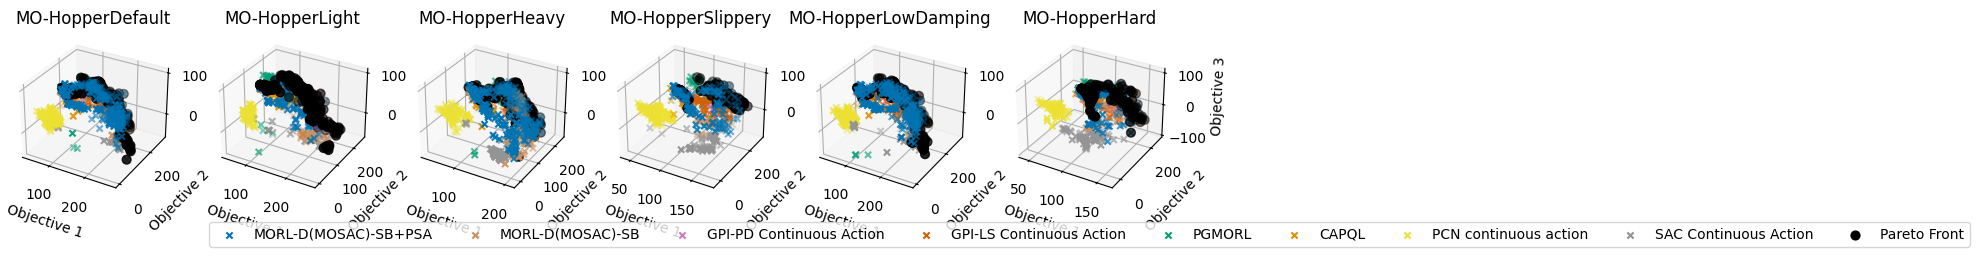

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Required for 3D plotting
from helpers.utils import ENVIRONMENTS_MAP, ENVIRONMENT_TO_ALGORITHMS_MAP, ALGORITHMS_COLOR_MAP, ALGORITHMS_NAME_MAP

ENV_NAME = "MOHopperDR-v5"
OBJECTIVE_DIM = 3  # Set to 2 or 3
FRONT = "eval/discounted_front"
file_path = f"data/{FRONT}/{ENV_NAME}"

ENVIRONMENTS = ENVIRONMENTS_MAP[ENV_NAME]
ALGORITHMS = ENVIRONMENT_TO_ALGORITHMS_MAP[ENV_NAME]
SEEDS = [5, 26, 47, 76, 92]

def get_non_pareto_dominated_inds(candidates, remove_duplicates: bool = True) -> np.ndarray:
    """A batched and fast version of the Pareto coverage set algorithm."""
    candidates = np.array(candidates)
    uniques, indcs, invs, counts = np.unique(candidates, return_index=True, return_inverse=True, return_counts=True, axis=0)

    res_eq = np.all(candidates[:, None, None] <= candidates, axis=-1).squeeze()
    res_g = np.all(candidates[:, None, None] < candidates, axis=-1).squeeze()
    c1 = np.sum(res_eq, axis=-1) == counts[invs]
    c2 = np.any(~res_g, axis=-1)
    if remove_duplicates:
        to_keep = np.zeros(len(candidates), dtype=bool)
        to_keep[indcs] = 1
    else:
        to_keep = np.ones(len(candidates), dtype=bool)

    return np.logical_and(c1, c2) & to_keep

def filter_pareto_dominated(candidates, remove_duplicates: bool = True) -> np.ndarray:
    """A batched and fast version of the Pareto coverage set algorithm."""
    candidates = np.array(candidates)
    if len(candidates) < 2:
        return candidates
    return candidates[get_non_pareto_dominated_inds(candidates, remove_duplicates=remove_duplicates)]

def rename_environment(env_name):
    # Remove the version part
    base_name = env_name.split('-')[0]
    # Insert a hyphen after "MO"
    renamed = base_name[:2] + '-' + base_name[2:]
    return renamed

# Create subplots for each environment
if OBJECTIVE_DIM == 2:
    fig, axes = plt.subplots(1, len(ENVIRONMENTS), figsize=(15, 5), constrained_layout=True)
elif OBJECTIVE_DIM == 3:
    fig = plt.figure(figsize=(15, 5))

for idx, env in enumerate(ENVIRONMENTS):
    if OBJECTIVE_DIM == 2:
        ax = axes[idx]
    elif OBJECTIVE_DIM == 3:
        ax = fig.add_subplot(1, len(ENVIRONMENTS), idx + 1, projection='3d')

    all_algo_points = []  # To store all points for all algorithms for this environment
    
    # Loop through algorithms and collect points
    for algo_idx, algo in enumerate(ALGORITHMS):
        algo_points = []  # Store points for this algorithm across all seeds
        for seed in SEEDS:
            file = f"{file_path}/{algo}/seed_{seed}/{env}.csv"
            assert os.path.exists(file), f"File {file} does not exist"
            
            # Read the CSV file
            data = pd.read_csv(file)
            # Collect all points based on OBJECTIVE_DIM
            points = data.values[:, -OBJECTIVE_DIM:]
            algo_points.append(points)

        # Concatenate points for this algorithm across seeds
        algo_points = np.vstack(algo_points)
        all_algo_points.append(algo_points)

        # Plot algorithm-specific points (with unique color)
        algo_name_2 = ALGORITHMS_NAME_MAP[algo]
        if OBJECTIVE_DIM == 2:
            ax.scatter(algo_points[:, 0], algo_points[:, 1], label=algo, color=ALGORITHMS_COLOR_MAP[algo_name_2], marker='x')
        elif OBJECTIVE_DIM == 3:
            ax.scatter(algo_points[:, 0], algo_points[:, 1], algo_points[:, 2], label=algo, color=ALGORITHMS_COLOR_MAP[algo_name_2], marker='x')

    # Combine points across all algorithms for Pareto front calculation
    combined_points = np.vstack(all_algo_points)
    
    # Filter Pareto-dominated points across all algorithms
    pareto_front = filter_pareto_dominated(combined_points)
    
    # Plot the Pareto front points in black
    if OBJECTIVE_DIM == 2:
        ax.scatter(pareto_front[:, 0], pareto_front[:, 1], label='Pareto Front', color='black', marker='o', s=40)
    elif OBJECTIVE_DIM == 3:
        ax.scatter(pareto_front[:, 0], pareto_front[:, 1], pareto_front[:, 2], label='Pareto Front', color='black', marker='o', s=40)

    # Customize plot
    ax.set_title(f'{rename_environment(env)}')
    ax.set_xlabel('Objective 1')
    ax.set_ylabel('Objective 2')
    if OBJECTIVE_DIM == 3:
        ax.set_zlabel('Objective 3')
    ax.grid(True)

# Add legend
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=len(ALGORITHMS)+1)

# Save and show plot
plt.savefig(f"images/pareto_fronts/{ENV_NAME}.svg", format='svg', bbox_inches='tight')
plt.show()
